In [1]:
# %%capture
# !pip install tensorflow-addons

In [2]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

2024-02-14 09:44:43.021119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 09:44:43.021180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-14 09:44:43.022642: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from IPython.display import Audio

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
os.environ["WANDB_SILENT"] = "true"
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical
from datasets import load_dataset, load_metric, Audio

In [5]:
%env WANDB_WATCH=all
%env WANDB_LOG_MODEL=1
!wandb login cabd5d56d2a152143db47f69e940d4713a37675a --relogin

env: WANDB_WATCH=all
env: WANDB_LOG_MODEL=1


In [6]:
data_path = "/kaggle/input/final-crema-features/unshift_features.csv"

In [7]:
data = pd.read_csv(data_path)

In [8]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,neutral,sad,twenties,thirties,forties,fifties,sixties,seventies,female,male
0,0.034180,0.069336,0.115723,0.148926,0.142090,0.130859,0.101562,0.070801,0.069336,0.074219,...,False,False,False,False,False,True,False,False,False,True
1,0.072266,0.134766,0.206543,0.235840,0.212402,0.174805,0.121094,0.090332,0.098633,0.107422,...,False,False,False,False,False,True,False,False,False,True
2,0.042480,0.083984,0.130371,0.144531,0.137207,0.114258,0.083008,0.073730,0.065430,0.075195,...,False,False,False,False,False,True,False,False,False,True
3,0.051270,0.097656,0.147949,0.164062,0.150879,0.125488,0.089844,0.079590,0.069336,0.079102,...,False,False,False,False,False,True,False,False,False,True
4,0.041504,0.059082,0.070312,0.062988,0.080566,0.128906,0.145508,0.146484,0.125977,0.072266,...,False,False,False,False,False,True,False,False,False,True


In [9]:
emo_ll = ['anxiety/fear', 'happiness', 'disgust', 'anger', 'sad', 'neutral']
gen_ll = ['female', 'male']
age_ll = ['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies']
emo_ll, gen_ll, age_ll

(['anxiety/fear', 'happiness', 'disgust', 'anger', 'sad', 'neutral'],
 ['female', 'male'],
 ['twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies'])

In [10]:
x = data.drop(emo_ll + gen_ll + age_ll, axis = 1).values
x

array([[0.03417969, 0.06933594, 0.11572266, ..., 0.        , 0.        ,
        0.        ],
       [0.07226562, 0.13476562, 0.20654297, ..., 0.        , 0.        ,
        0.        ],
       [0.04248047, 0.08398438, 0.13037109, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.21533203, 0.24853516, 0.30517578, ..., 0.        , 0.        ,
        0.        ],
       [0.22119141, 0.28320312, 0.31884766, ..., 0.        , 0.        ,
        0.        ],
       [0.22021484, 0.29003906, 0.32763672, ..., 0.        , 0.        ,
        0.        ]])

In [12]:
y = data[emo_ll + gen_ll + age_ll].values
y

array([[False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [13]:
y_emo = data[emo_ll].values
y_gen = data[gen_ll].values
y_age = data[age_ll].values
y_emo, y_gen, y_age

(array([[False, False, False,  True, False, False],
        [False, False, False,  True, False, False],
        [False, False, False,  True, False, False],
        ...,
        [False, False, False, False,  True, False],
        [False, False, False, False,  True, False],
        [False, False, False, False,  True, False]]),
 array([[False,  True],
        [False,  True],
        [False,  True],
        ...,
        [ True, False],
        [ True, False],
        [ True, False]]),
 array([[False, False, False,  True, False, False],
        [False, False, False,  True, False, False],
        [False, False, False,  True, False, False],
        ...,
        [False,  True, False, False, False, False],
        [False,  True, False, False, False, False],
        [False,  True, False, False, False, False]]))

In [14]:
y_gen.shape, y_emo.shape, y_age.shape

((29768, 2), (29768, 6), (29768, 6))

In [15]:
x_train, x_valtest, y_gen_train, y_gen_valtest, y_emo_train, y_emo_valtest, y_age_train, y_age_valtest = train_test_split(x, y_gen, y_emo, y_age, test_size=0.3, random_state=30)
x_test, x_val, y_gen_test, y_gen_val, y_emo_test, y_emo_val, y_age_test, y_age_val = train_test_split(x_valtest, y_gen_valtest, y_emo_valtest, y_age_valtest, test_size=0.5, random_state=30)

In [16]:
scaler = StandardScaler()

In [17]:
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

x_train.shape, x_test.shape, x_val.shape

((20837, 2376), (4465, 2376), (4466, 2376))

In [18]:
config = {
    "loss": {'emotion': 'categorical_crossentropy',
             'age': 'categorical_crossentropy',
             'gender': 'binary_crossentropy'},
    "metric": {'emotion': 'accuracy',
               'age': 'accuracy',
               'gender': 'accuracy'},
    "epochs": 200,
    "batch_size" : 32
    }

In [19]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Layer, Conv1D, BatchNormalization, MaxPooling1D, 
                                     AveragePooling1D, Dropout, Flatten, Dense, 
                                     Input, Softmax, Dot, Reshape, GlobalAveragePooling1D,
                                     GlobalMaxPool1D, Add, Activation, multiply, Concatenate)

## Model Code:

In [20]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, inputs):
        # Compute attention scores
        score = tf.nn.tanh(self.W(inputs))
        attention_weights = tf.nn.softmax(self.V(score), axis = 1)

        # Apply attention weights to input
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis = 1)

        return context_vector

In [21]:
input_layer = Input(shape=(x_train.shape[1], 1))

n = 512

# hidden layer 1
hl = Conv1D(n, kernel_size=5, strides=1, padding='same', activation='gelu')(input_layer)
hl = BatchNormalization()(hl)
hl = AveragePooling1D(pool_size=3, strides=2, padding='same')(hl)
hl = Dropout(0.2)(hl)

# attention layer 1
al1 = Attention(n * 4)(hl)

# hidden layer 2
hl = Conv1D(n // 2, kernel_size=3, strides=1, padding='same', activation='gelu')(hl)
hl = BatchNormalization()(hl)
hl = AveragePooling1D(pool_size=3, strides=1, padding='same')(hl)
hl = Dropout(0.2)(hl)

# attention layer 2
al2 = Attention(n * 2)(hl)

# hidden layer 3
hl = Conv1D(n // 4, kernel_size=3, strides=1, padding='same', activation='gelu')(hl)
hl = BatchNormalization()(hl)
hl = AveragePooling1D(pool_size=3, strides=1, padding='same')(hl)
hl = Dropout(0.2)(hl)

# attention layer 3
al3 = Attention(n)(hl)

ao = Concatenate(axis=1)([al1, al2, al3])

# dense layers for the shared layer
# hl = Dense(64, activation='relu')(al3)
# hl = BatchNormalization()(hl)
# hl = Dropout(0.2)(hl)

# Output layers for each task
emotion_output = Dense(y_emo_train.shape[1], activation='softmax', name='emotion')(ao)
age_output = Dense(y_age_train.shape[1], activation='softmax', name='age')(ao)
gender_output = Dense(y_gen_train.shape[1], activation='softmax', name='gender')(ao)

# Create the model with multiple outputs
model = Model(inputs=input_layer, outputs=[emotion_output, age_output, gender_output])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2376, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 2376, 512)            3072      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 2376, 512)            2048      ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 average_pooling1d (Average  (None, 1188, 512)            0         ['batch_normalization[0][0

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model
a = plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
early_stop_emotion = EarlyStopping(monitor='val_emotion_accuracy', mode='auto', patience=10, restore_best_weights=True)
early_stop_age = EarlyStopping(monitor='val_age_accuracy', mode='auto', patience=10, restore_best_weights=True)
early_stop_gender = EarlyStopping(monitor='val_gender_accuracy', mode='auto', patience=10, restore_best_weights=True)

In [25]:
lr_reduction_emotion = ReduceLROnPlateau(monitor='val_emotion_accuracy', verbose=1, factor=0.5)
lr_reduction_age = ReduceLROnPlateau(monitor='val_age_accuracy', verbose=1, factor=0.5)
lr_reduction_gender = ReduceLROnPlateau(monitor='val_gender_accuracy', verbose=1, factor=0.5)

In [26]:
opt = keras.optimizers.legacy.Nadam()
optimizer = tfa.optimizers.Lookahead(opt)

In [27]:
model.compile(optimizer=optimizer,
              loss = config["loss"],
#               loss_weights = [2., 2., 1.],
              metrics = config["metric"])

In [28]:
run = wandb.init(
    project="kms",
    config=config,
    entity="segaa"
)

In [29]:
callbacks = [
    lr_reduction_emotion,
    lr_reduction_age,
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath="models/")
    ]

In [30]:
history = model.fit(x_train, {'emotion': y_emo_train,
                              'age': y_age_train,
                              'gender': y_gen_train,},
          validation_data=(x_val, {'emotion': y_emo_val,
                                   'age': y_age_val,
                                   'gender': y_gen_val}),
          epochs=run.config.epochs, batch_size=run.config.batch_size, callbacks=callbacks)

Epoch 1/200
652/652 [==============================] - 108s 148ms/step - loss: 3.7481 - emotion_loss: 1.5943 - age_loss: 1.5268 - gender_loss: 0.6270 - emotion_accuracy: 0.3329 - age_accuracy: 0.3349 - gender_accuracy: 0.6383 - val_loss: 4.0719 - val_emotion_loss: 1.8753 - val_age_loss: 1.5681 - val_gender_loss: 0.6285 - val_emotion_accuracy: 0.2602 - val_age_accuracy: 0.2611 - val_gender_accuracy: 0.6494 - lr: 0.0010
Epoch 2/200
652/652 [==============================] - 94s 145ms/step - loss: 3.4491 - emotion_loss: 1.4871 - age_loss: 1.4764 - gender_loss: 0.4855 - emotion_accuracy: 0.3887 - age_accuracy: 0.3570 - gender_accuracy: 0.7684 - val_loss: 4.1694 - val_emotion_loss: 1.9100 - val_age_loss: 1.7560 - val_gender_loss: 0.5034 - val_emotion_accuracy: 0.2696 - val_age_accuracy: 0.2091 - val_gender_accuracy: 0.7519 - lr: 0.0010
Epoch 3/200
652/652 [==============================] - 94s 145ms/step - loss: 3.2931 - emotion_loss: 1.4412 - age_loss: 1.4529 - gender_loss: 0.3990 - emotio

KeyboardInterrupt: 

In [31]:
run.finish()

wandb: WARNING No program path found when generating artifact job source for a non-colab notebook run. See https://docs.wandb.ai/guides/launch/create-job
wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [32]:
losses = model.evaluate(x_test, {'emotion': y_emo_test,
                                 'age': y_age_test,
                                 'gender': y_gen_test})
print('Emotion Loss:', losses[1])
print('Age Loss:', losses[2])
print('Gender Loss:', losses[3])
print('Emotion Accuracy:', losses[4])
print('Age Accuracy:', losses[5])
print('Gender Accuracy:', losses[6])

140/140 [==============================] - 6s 40ms/step - loss: 2.3228 - emotion_loss: 1.0989 - age_loss: 1.0750 - gender_loss: 0.1489 - emotion_accuracy: 0.5957 - age_accuracy: 0.5881 - gender_accuracy: 0.9442
Emotion Loss: 1.0989149808883667
Age Loss: 1.0750396251678467
Gender Loss: 0.14886081218719482
Emotion Accuracy: 0.5957446694374084
Age Accuracy: 0.5881298780441284
Gender Accuracy: 0.9442329406738281


In [33]:
checkpoint_path = "training_1/attention.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [35]:
y_pred = model.predict(x_test)

140/140 [==============================] - 6s 37ms/step


In [36]:
y_emo_pred = np.argmax(y_pred[0], axis=1)
y_age_pred = np.argmax(y_pred[1], axis=1)
y_gen_pred = (y_pred[2] > 0.5).astype(int)

In [37]:
set(y_age_pred)

{0, 1, 2, 3, 4, 5}

In [38]:
y_gen_test.shape, y_age_test.shape, y_emo_test.shape

((4465, 2), (4465, 6), (4465, 6))

In [39]:
emo_cm = confusion_matrix(np.argmax(y_emo_test, axis=1), y_emo_pred)
age_cm = confusion_matrix(np.argmax(y_age_test, axis=1), y_age_pred)
gen_cm = confusion_matrix(np.argmax(y_gen_test, axis=1), np.argmax(y_gen_pred, axis=1))

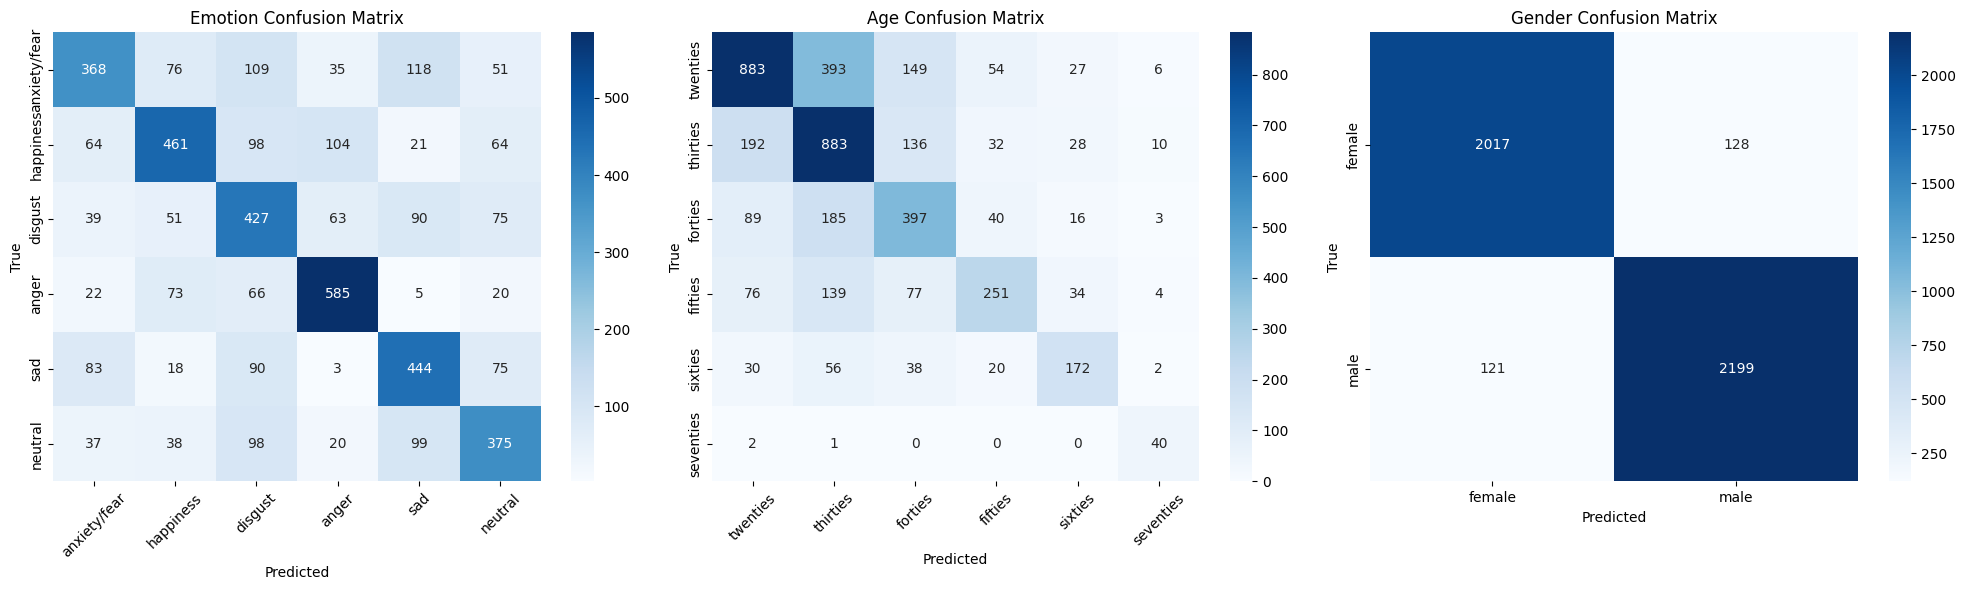

In [43]:
labels_emotion = ['Anger', 'Anxiety/Fear', 'Disgust', 'Happiness', 'Neutral', 'Sadness']
labels_age = ['Twenties', 'Thirties', 'Forties', 'Fifties', 'Sixties', 'Seventies']
labels_gender = ['Male', 'Female']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(emo_cm, annot=True, cmap='Blues', fmt='d', ax=axes[0])
axes[0].set_xticks(np.arange(len(emo_ll)) + 0.5)
axes[0].set_yticks(np.arange(len(emo_ll)) + 0.5)
axes[0].set_xticklabels(emo_ll, rotation=45)
axes[0].set_yticklabels(emo_ll)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Emotion Confusion Matrix')

sns.heatmap(age_cm, annot=True, cmap='Blues', fmt='d', ax=axes[1])
axes[1].set_xticks(np.arange(len(age_ll)) + 0.5)
axes[1].set_yticks(np.arange(len(age_ll)) + 0.5)
axes[1].set_xticklabels(age_ll, rotation=45)
axes[1].set_yticklabels(age_ll)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Age Confusion Matrix')

sns.heatmap(gen_cm, annot=True, cmap='Blues', fmt='d', ax=axes[2])
axes[2].set_xticks(np.arange(len(gen_ll)) + 0.5)
axes[2].set_yticks(np.arange(len(gen_ll)) + 0.5)
axes[2].set_xticklabels(gen_ll)
axes[2].set_yticklabels(gen_ll)
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')
axes[2].set_title('Gender Confusion Matrix')


plt.tight_layout()
plt.show()

In [45]:
print(classification_report(np.argmax(y_emo_test, axis=1), y_emo_pred, target_names=emo_ll))
print(classification_report(np.argmax(y_age_test, axis=1), y_age_pred, target_names=age_ll))
print(classification_report(y_gen_test, y_gen_pred, target_names=gen_ll))

              precision    recall  f1-score   support

anxiety/fear       0.60      0.49      0.54       757
   happiness       0.64      0.57      0.60       812
     disgust       0.48      0.57      0.52       745
       anger       0.72      0.76      0.74       771
         sad       0.57      0.62      0.60       713
     neutral       0.57      0.56      0.57       667

    accuracy                           0.60      4465
   macro avg       0.60      0.60      0.59      4465
weighted avg       0.60      0.60      0.60      4465

              precision    recall  f1-score   support

    twenties       0.69      0.58      0.63      1512
    thirties       0.53      0.69      0.60      1281
     forties       0.50      0.54      0.52       730
     fifties       0.63      0.43      0.51       581
     sixties       0.62      0.54      0.58       318
   seventies       0.62      0.93      0.74        43

    accuracy                           0.59      4465
   macro avg       0.60